# Uber Data Analytics Project / EXECUTIVE SUMMARY

Questions to be answered;
What is the distribution of total bookings over time?
How do average ratings for customers and drivers vary by time of day or day of the week?
hat is the distribution of ride cancellation reasons for both customers and drivers?
Does the time a driver takes to arrive at a pickup location (Avg VTAT) impact whether a ride is canceled?
How does the average time a driver takes to arrive at a pickup location (Avg VTAT) correlate with customer rating? 
Calculate the cancellation rate for each vehicle type and identify which type has the highest rate.

# Data Sourcing and Loading:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("ncr_ride_bookings.csv")

# Exploratory Data Analysis EDA
## General Information

In [2]:
#getting an overview of all the columns and datatypes
print(df.head())
#confirming the size of the dataframe
print(df.shape)
#general info on values
print(df.describe())


         Date      Time    Booking ID   Booking Status   Customer ID  \
0  2024-03-23  12:29:38  "CNR5884300"  No Driver Found  "CID1982111"   
1  2024-11-29  18:01:39  "CNR1326809"       Incomplete  "CID4604802"   
2  2024-08-23  08:56:10  "CNR8494506"        Completed  "CID9202816"   
3  2024-10-21  17:17:25  "CNR8906825"        Completed  "CID2610914"   
4  2024-09-16  22:08:00  "CNR1950162"        Completed  "CID9933542"   

    Vehicle Type      Pickup Location      Drop Location  Avg VTAT  Avg CTAT  \
0          eBike          Palam Vihar            Jhilmil       NaN       NaN   
1       Go Sedan        Shastri Nagar  Gurgaon Sector 56       4.9      14.0   
2           Auto              Khandsa      Malviya Nagar      13.4      25.8   
3  Premier Sedan  Central Secretariat           Inderlok      13.1      28.5   
4           Bike     Ghitorni Village        Khan Market       5.3      19.6   

   ...  Reason for cancelling by Customer Cancelled Rides by Driver  \
0  ...         

## Investigating the 'Booking Status' column

Booking Status
Cancelled by Customer    10500
Cancelled by Driver      27000
Completed                93000
Incomplete                9000
No Driver Found          10500
Name: Booking Status, dtype: int64


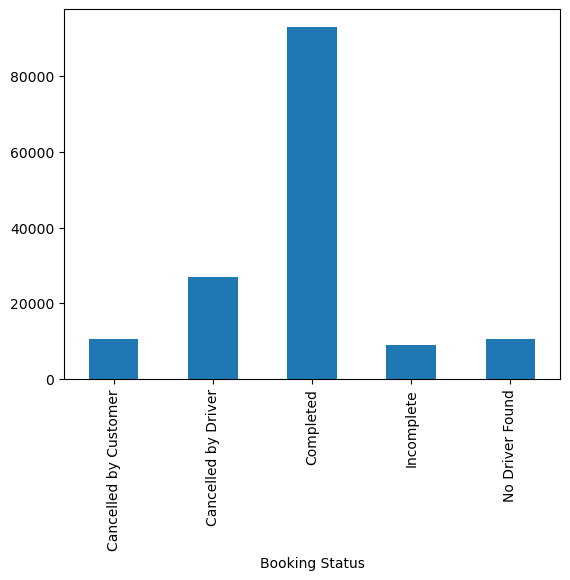

In [3]:
df.groupby('Booking Status').size().plot(kind='bar')
print(df.groupby('Booking Status')['Booking Status'].size())

status_cancelled_customer = (df['Booking Status']=='Cancelled by Customer')
status_cancelled_driver = (df['Booking Status']=='Cancelled by Driver')
status_complete = (df['Booking Status']=='Complete')
status_incomplete = (df['Booking Status']=='Incomplete')
status_no_driver_found = (df['Booking Status']=='No Driver Found')

total_rides_not_finished = status_cancelled_customer + status_cancelled_driver + status_incomplete + status_no_driver_found
total_rides_not_started = status_cancelled_customer + status_cancelled_driver + status_no_driver_found


### Validating the Booking Status

In [10]:
rides_cancelled_customer = df['Cancelled Rides by Customer'].notna()
rides_cancelled_driver = df['Cancelled Rides by Driver'].notna()
rides_incomplete = df['Incomplete Rides'].notna()

total_diff_rides_cancelled_customer_status = (rides_cancelled_customer!= status_cancelled_customer).sum()
assert total_diff_rides_cancelled_customer_status == 0, "Validation Failed: Found {total_diff_rides_cancelled_customer_status} rows overlapping categories"

total_diff_rides_cancelled_driver_status = (rides_cancelled_driver != status_cancelled_driver).sum()
assert total_diff_rides_cancelled_driver_status == 0, "Validation Failed: Found {total_diff_rides_cancelled_driver_status} rows overlapping categories"

total_diff_rides_incomplete_status = (rides_incomplete != status_incomplete).sum()
assert total_diff_rides_incomplete_status == 0, "Validation Failed: Found {total_diff_rides_incomplete_status} rows overlapping categories"

print("Validation for Booking Status successful")


Validation for Booking Status successful


## Investigating missing values


In [5]:
#total amount of null-values per column
print(df.isna().sum())

Date                                      0
Time                                      0
Booking ID                                0
Booking Status                            0
Customer ID                               0
Vehicle Type                              0
Pickup Location                           0
Drop Location                             0
Avg VTAT                              10500
Avg CTAT                              48000
Cancelled Rides by Customer          139500
Reason for cancelling by Customer    139500
Cancelled Rides by Driver            123000
Driver Cancellation Reason           123000
Incomplete Rides                     141000
Incomplete Rides Reason              141000
Booking Value                         48000
Ride Distance                         48000
Driver Ratings                        57000
Customer Rating                       57000
Payment Method                        48000
dtype: int64


### Validating VTAT and CTAT

The  missing values in the column 'Avg VTAT', i.e. the average time for the driver to reach the pickup location, correspond to the rides where no driver could be found.

The missing values in the column 'Avg CTAT', i.e the average trip duration from pickup to destination, correspond to the rides that have never been started, meaning they have the status Cancelled by Customer, Cancelled by Driver or No Driver Found.

In [6]:
nas_vtat = df['Avg VTAT'].isna()
nas_ctat = df['Avg CTAT'].isna()

total_diff_nas_vtat_no_driver_found = ((nas_vtat.astype(int) + status_no_driver_found.astype(int)) == 1).sum()
assert total_diff_nas_vtat_no_driver_found == 0, "Validation Failed: Found {total_diff_nas_vtat_no_driver_found} rows overlapping categories"

total_diff_nas_ctat_rides_not_started = ((nas_ctat.astype(int) + total_rides_not_started.astype(int)) == 1).sum()
assert total_diff_nas_ctat_rides_not_started== 0, "Validation Failed: Found {total_diff_nas_ctat_rides_not_started} rows overlapping categories"

print("Validation for VTAT and CTAT successful")


Validation for VTAT and CTAT successful


### Validating Cancelled & Incomplete Rides

The columns for 'Cancelled Rides by Customer' have 139'500 missing values. This is expected as a value of 1.0 is only recorded when the ride indeed has been cancelled. This number of missing values also corresponds to the amount of missing values of the column 'Reason for cancelling by Customer'. The similar reasoning can be applied for the columns 'Cancelled Rides by Driver' and 'Driver Cancellation Reason' as well as 'Incomplete Rides' and 'Incomplete Rides Reason'.

In [7]:
#identify rows where rides have been cancelled or are incomplete
cancelled_customer = df['Cancelled Rides by Customer'].notna()
cancelled_driver = df['Cancelled Rides by Driver'].notna()
incomplete_ride = df['Incomplete Rides'].notna()

#check for the total number of rides that have both the booking status 'No Driver Found' and an entry in the 'Cancelled by Customer' column as both are the same size
no_driver_found_cancelled_customer_overlaps = (status_no_driver_found & cancelled_customer).sum()
assert no_driver_found_cancelled_customer_overlaps == 0, "Validation Failed: Found {no_driver_found_cancelled_customer_overlaps} rows overlapping categories"

#check for the total number of rides that have more than one entry in the cancelled or incomplete columnns
num_overlaps = ((cancelled_customer.astype(int) + cancelled_driver.astype(int) + incomplete_ride.astype(int)) > 1).sum()
assert num_overlaps == 0, "Validation Failed: Found {num_overlaps} rows overlapping categories"

#check for mismatches
cancelled_customer_reason = df['Reason for cancelling by Customer'].notna()
cancelled_driver_reason = df['Driver Cancellation Reason'].notna() 
incomplete_ride_reason = df['Incomplete Rides Reason'].notna()

total_diff_cancelled_customer_reason = (cancelled_customer!=cancelled_customer_reason).sum()
assert total_diff_cancelled_customer_reason == 0, "Validation Failed: Found {total_diff_cancelled_customer_reason} rows overlapping categories"

total_diff_cancelled_driver_reason = (cancelled_driver!=cancelled_driver_reason).sum()
assert total_diff_cancelled_driver_reason == 0, "Validation Failed: Found {total_diff_cancelled_driver_reason} rows overlapping categories"

total_diff_incomplete_ride_reason = (incomplete_ride!=incomplete_ride_reason).sum()
assert total_diff_incomplete_ride_reason == 0, "Validation Failed: Found {total_diff_incomplete_ride_reason} rows overlapping categories"

print("Validation for Cancelled and Incomplete Rides successful")


Validation for Cancelled and Incomplete Rides successful


### Validating Booking Value, Ride Distance and Payment Method 

The rows where no Booking Value, Ride Distance and Payment Method where recorded correspond to the rides that have never been started, i.e. they have no 'Avg CTAT' entry which has been validated above.

In [8]:
nas_booking_value = df['Booking Value'].isna()
nas_ride_distance = df['Ride Distance'].isna()
nas_payment_method = df['Payment Method'].isna()

total_diff_booking_value_ride_distance_payment_method = ((nas_booking_value!=nas_ride_distance) | (nas_ride_distance!=nas_payment_method)).sum()
assert total_diff_booking_value_ride_distance_payment_method == 0, "Validation Failed: Found {total_diff_booking_value_ride_distance_payment_method} rows overlapping categories"

total_diff_rides_not_started_no_booking = (total_rides_not_started!=nas_booking_value).sum()
assert total_diff_rides_not_started_no_booking == 0, "Validation Failed: Found {total_diff_rides_not_started_no_booking} rows overlapping categories"

total_diff_rides_not_started_no_ride = (total_rides_not_started!=nas_ride_distance).sum()
assert total_diff_rides_not_started_no_ride == 0, "Validation Failed: Found {total_diff_rides_not_started_no_ride} rows overlapping categories"

total_diff_rides_not_started_no_payment = (total_rides_not_started!=nas_payment_method).sum()
assert total_diff_booking_value_ride_distance_payment_method == 0, "Validation Failed: Found {total_diff_booking_value_ride_distance_payment_method} rows overlapping categories"

print("Validation for Booking Value, Ride Distance and Payment Method successful")



Validation for Booking Value, Ride Distance and Payment Method successful


### Validating Driver and Customer Ratings

In [9]:
nas_driver_ratings = df['Driver Ratings'].isna()
nas_customer_ratings = df['Driver Ratings'].isna()

total_diff_driver_customer_ratings = (nas_driver_ratings != nas_customer_ratings).sum()
assert total_diff_driver_customer_ratings == 0, "Validation Failed: Found {total_diff_driver_customer_ratings} rows with overlapping categories."

total_diff_rides_not_finished_driver_ratings = (nas_driver_ratings != total_rides_not_finished).sum()
assert total_diff_rides_not_finished_driver_ratings == 0, "Validation Failed: Found {total_diff_rides_not_finished_driver_ratings} rows with overlapping categories."

total_diff_rides_not_finished_customer_ratings = (nas_customer_ratings != total_rides_not_finished).sum()
assert total_diff_rides_not_finished_customer_ratings == 0, "Validation Failed: Found {total_diff_rides_not_finished_customer_ratings} rows with overlapping categories."

print("Validation for Driver and Customer Ratings successful")


Validation for Driver and Customer Ratings successful
